In [1]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from models import RNNGC
from dataset import DatasetMaker

In [2]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units
alpha = 0.88

In [3]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng, alpha = alpha)
model = model.load("./best_models/RNNGC.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [4]:
dataset = DatasetMaker()

(-6.283185307179586, 6.283185307179586, -6.283185307179586, 6.283185307179586)

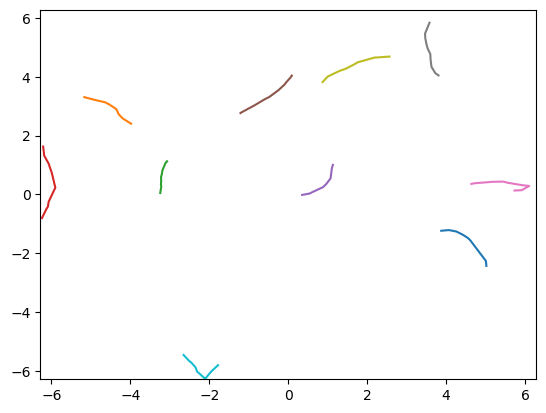

In [5]:
rt, vt = dataset.generate_data(10, timesteps, "cpu")

for i in range(10):
  plt.plot(rt[i,...,0], rt[i,...,1])
plt.axis(2*np.pi*np.array([-1, 1, -1, 1]))

In [6]:
loss_history = []
for i in tqdm(range(train_steps-len(model.total_loss_history))):
    r, v = dataset.generate_data(bs, timesteps, device)
    loss = model.train_step(inputs = (r[:,0], v), labels = r, optimizer = optimizer)
    loss_history.append(loss.item())
#model.save("./best_models/RNNGC.pkl")

0it [00:00, ?it/s]


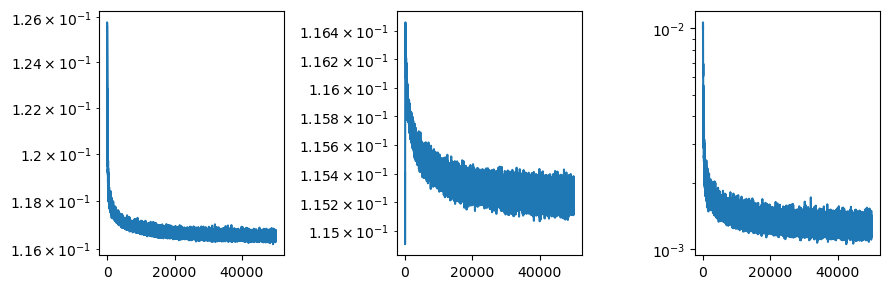

In [7]:
fig,axs = plt.subplots(1,3,figsize=(9,3))
axs[0].semilogy(np.array(model.total_loss_history)-model.loss_minima())
axs[1].semilogy(np.array(model.capacity_loss_history)-model.loss_minima())
axs[2].semilogy(model.similarity_loss_history)
fig.tight_layout()

In [8]:
r, v = dataset.generate_data(10000, timesteps, device)
g = model((r[:,0], v))

r = r.detach().cpu().numpy()
g = g.detach().cpu().numpy()

In [9]:
ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

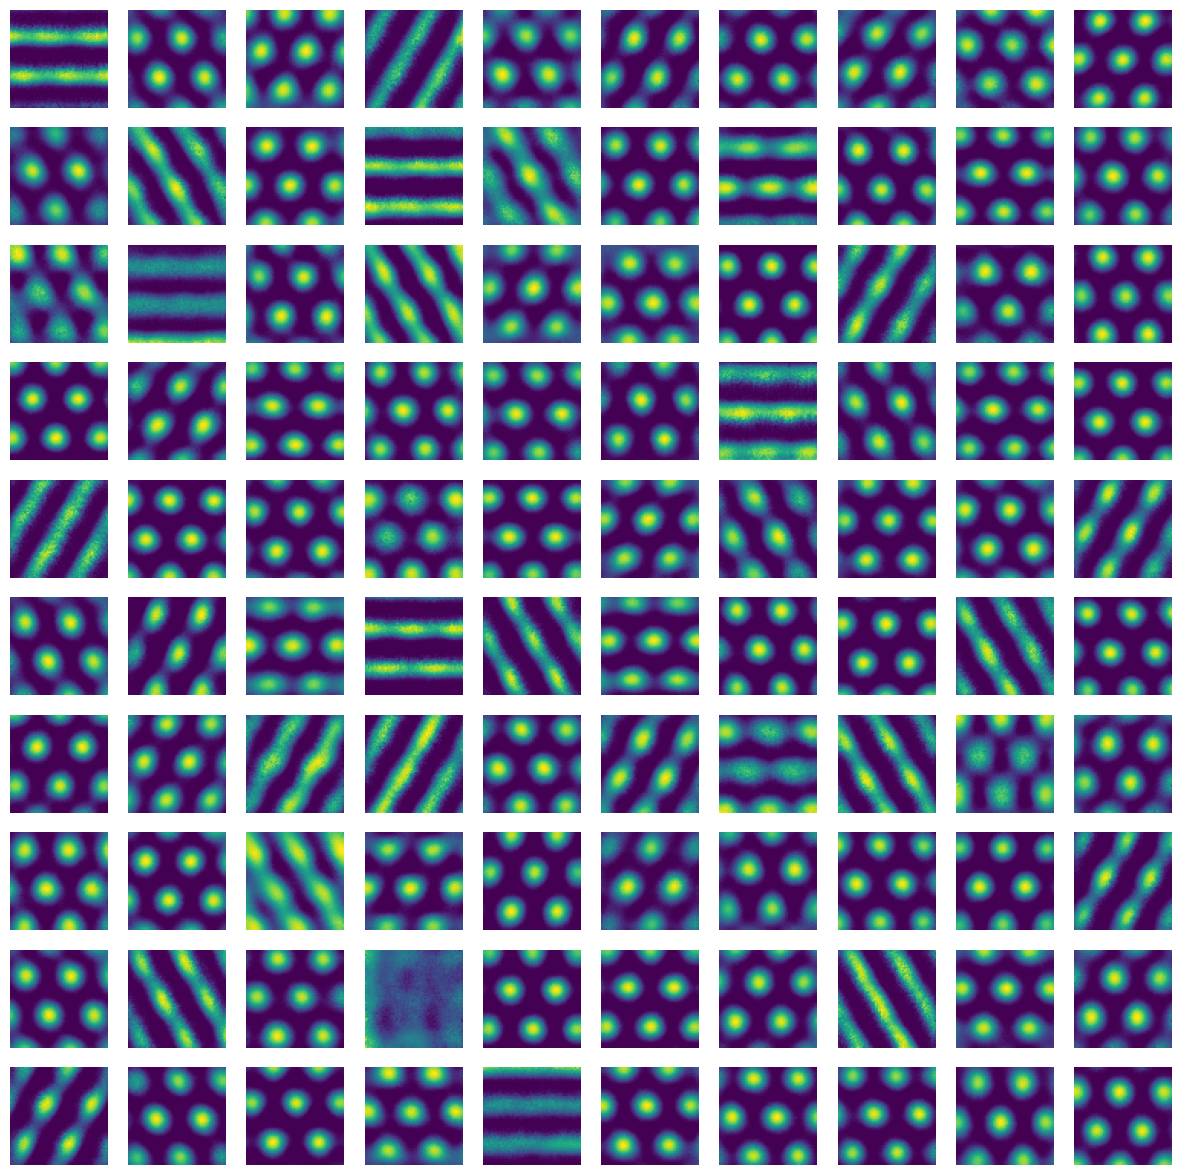

In [10]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1